In [1]:
import numpy as np
import pandas as pd   
import datetime
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import sys
sys.path.insert(0,'..')
import module as mod

from keras.layers import Dropout, Layer, LSTM, Dense, BatchNormalization, Activation, Input
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import backend as K

#from kerashypetune import KerasGridSearch

This notebook is an adaptation of the following Git repository : https://github.com/cerlymarco/MEDIUM_NoteBook/tree/master/Time2Vec

# 0. Load and prepare our dataset
First we declare our global variables

In [2]:
### DEFINE GLOBAL VARIABLES ###
TIME_STEP = datetime.timedelta(minutes=1, seconds=30) # duration of a step in the resample dataset, originally 1 second
DURATION_TIME = datetime.timedelta(minutes=60) # duration of a sequence
OVERLAP_PERIOD_PERCENT = 0.8 # 0.5 <=> 50% overlapping

SEQUENCE_LENGTH, OVERLAP_PERIOD = mod.convertToSequenceParameters(TIME_STEP, DURATION_TIME, OVERLAP_PERIOD_PERCENT)

Then we load our datasets

In [3]:
### READ DATA ###

house1_power_blk2 = mod.load_dataset('house1_power_blk2_labels.zip', resample_period=TIME_STEP)
#house1_power_blk2['activity'] = (house1_power_blk2['activity'] > 0.5).astype(int)
house2_power_blk1 = mod.load_dataset('house2_power_blk1_labels.zip', resample_period=TIME_STEP)
#house2_power_blk1['activity'] = (house2_power_blk1['activity'] > 0.5).astype(int)
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.000000
2016-03-06 00:01:30,483.0,0,0.016667
2016-03-06 00:03:00,474.0,0,0.050000
2016-03-06 00:04:30,483.0,0,0.066667
2016-03-06 00:06:00,477.0,0,0.100000


We'll normalize each dataset with a ```MinMaxScaler``` fitted on 70% of each dataset which we'll use a train set. After a few tests, normalizing the electrical power data is necessary to get better results for our final classification, more specifically to use one house as a training dataset and another as a testing dataset.

In [4]:
### SCALE THE DATASETS ###

step = SEQUENCE_LENGTH - OVERLAP_PERIOD

# scale the dataset
train_dim_h1 = int(0.7*len(house1_power_blk2) / step)
train_dim_h2 = int(0.7*len(house2_power_blk1) / step)

scaler = MinMaxScaler()
scaler.fit(house1_power_blk2['mains'].iloc[:train_dim_h1].values.reshape(-1, 1))
house1_power_blk2['mains'] = scaler.transform(house1_power_blk2['mains'].values.reshape(-1, 1))
#house1_power_blk2['off_peak'] = ((house1_power_blk2['hour'] > 6) & (house1_power_blk2['hour'] < 23)).astype(int)

scaler = MinMaxScaler()
scaler.fit(house2_power_blk1['mains'].iloc[:train_dim_h2].values.reshape(-1, 1))
house2_power_blk1['mains'] = scaler.transform(house2_power_blk1['mains'].values.reshape(-1, 1))
#house2_power_blk1['off_peak'] = ((house2_power_blk1['hour'] > 6) & (house2_power_blk1['hour'] < 23)).astype(int)

house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,0.017080,0,0.000000
2016-03-06 00:01:30,0.018168,0,0.016667
2016-03-06 00:03:00,0.017189,0,0.050000
2016-03-06 00:04:30,0.018168,0,0.066667
2016-03-06 00:06:00,0.017515,0,0.100000


In [5]:
### CREATE GENERATOR FOR LSTM AND T2V ###

# we define a function to generate our sequences
def gen_sequence(id_df, seq_length, overlap_period, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    step = seq_length - overlap_period

    for start, stop in zip(range(0, num_elements-seq_length, step), range(seq_length, num_elements, step)):
        yield data_matrix[start:stop, :]

# this function is usefull in the case that we only predict 1 data point for each sequence
def gen_labels(id_df, seq_length, overlap_period, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    step = seq_length - overlap_period
    
    return data_matrix[seq_length:num_elements:step, :]

# we define a utility function to unfold our sequences
def unfold_sequence(y_seq, seq_length, overlap_period):
    step = seq_length - overlap_period
    y_unfolded = np.zeros((y_seq.shape[0]*step, ))
    y_weight = np.zeros((y_seq.shape[0]*step, ))

    for i in range(seq_length):
        y_unfolded[i::step] += y_seq[:-int(i/step) if int(i/step) > 0 else None,i,0]
        y_weight[i::step] += 1

    return y_unfolded/y_weight

# 1. Train our embeddings

Next we need to prepare the data in batches for Keras.

In [6]:
### HOUSE 1 ###
X_h1, Y_h1 = [], []
for sequence in gen_sequence(house1_power_blk2, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    X_h1.append(sequence)
    
    # gen_labels
for sequence in gen_sequence(house1_power_blk2, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    Y_h1.append(sequence)
    
X_h1 = np.asarray(X_h1)
Y_h1 = np.asarray(Y_h1)

In [7]:
### HOUSE 2 ###

# prepare the batches
X_h2, Y_h2 = [], []
for sequence in gen_sequence(house2_power_blk1, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    X_h2.append(sequence)
    
for sequence in gen_sequence(house2_power_blk1, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    Y_h2.append(sequence)
    
X_h2 = np.asarray(X_h2)
Y_h2 = np.asarray(Y_h2)

In [8]:
### TRAIN TEST SPLIT HOUSE 1 ###
X_train_h1, X_test_h1 = X_h1[:train_dim_h1], X_h1[train_dim_h1:]
y_train_h1, y_test_h1 = Y_h1[:train_dim_h1], Y_h1[train_dim_h1:]

print(X_train_h1.shape, y_train_h1.shape)
print(X_test_h1.shape, y_test_h1.shape)

(5288, 40, 1) (5288, 40, 1)
(2262, 40, 1) (2262, 40, 1)


In [9]:
### TRAIN TEST SPLIT HOUSE 2 ###

X_train_h2, X_test_h2 = X_h2[:train_dim_h2], X_h2[train_dim_h2:]
y_train_h2, y_test_h2 = Y_h2[:train_dim_h2], Y_h2[train_dim_h2:]

print(X_train_h2.shape, y_train_h2.shape)
print(X_test_h2.shape, y_test_h2.shape)

(4959, 40, 1) (4959, 40, 1)
(2121, 40, 1) (2121, 40, 1)


In [10]:
### DEFINE T2V LAYER ###

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [11]:
### DEFINE MODEL STRUCTURES ###

# def set_seed(seed):
    
#     tf.random.set_seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     random.seed(seed)

def T2V_NN(param, dim):
    
    # set_seed(33)
    
    inp = Input(shape=(dim,1))
    #x = Dropout(0.2)(inp)
    x = T2V(param['t2v_dim'])(inp)
    x = Dropout(0.2)(x)
    # return_sequences=False : ne retourne que le dernier état
    # x = LSTM(param['unit'], activation=param['act'], return_sequences=True)(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer='adam') #Adam(learning_rate=param['lr'])
    
    return m

In [12]:
### DEFINE PARAM GRID FOR HYPERPARM OPTIMIZATION ###

early_stop = EarlyStopping(patience=3, verbose=0, min_delta=0.0001, monitor='loss', mode='auto', restore_best_weights=True)

best_params = {'unit': 32, 't2v_dim': 128, 'lr': 0.001, 'act': 'relu', 'epochs': 20, 'batch_size': 1024}
kgs_t2v = T2V_NN(param=best_params, dim=SEQUENCE_LENGTH)
kgs_t2v.summary();

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 1)]           0         
                                                                 
 t2v (T2V)                   (None, 40, 129)           5328      
                                                                 
 dropout (Dropout)           (None, 40, 129)           0         
                                                                 
 dense (Dense)               (None, 40, 1)             130       
                                                                 
Total params: 5,458
Trainable params: 5,458
Non-trainable params: 0
_________________________________________________________________


2022-06-02 16:56:12.123143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 16:56:12.130659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 16:56:12.130908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 16:56:12.131694: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [78]:
### TRAIN MODEL ON HOUSE 1 ###
kgs_t2v.fit(X_train_h1, y_train_h1, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

Epoch 1/20
6/6 [==============================] - 1s 24ms/step - loss: 0.0148
Epoch 2/20
6/6 [==============================] - 0s 25ms/step - loss: 0.0091
Epoch 3/20
6/6 [==============================] - 0s 26ms/step - loss: 0.0076
Epoch 4/20
6/6 [==============================] - 0s 26ms/step - loss: 0.0059
Epoch 5/20
6/6 [==============================] - 0s 27ms/step - loss: 0.0046
Epoch 6/20
6/6 [==============================] - 0s 26ms/step - loss: 0.0034
Epoch 7/20
6/6 [==============================] - 0s 26ms/step - loss: 0.0025
Epoch 8/20
6/6 [==============================] - 0s 26ms/step - loss: 0.0018
Epoch 9/20
6/6 [==============================] - 0s 26ms/step - loss: 0.0013
Epoch 10/20
6/6 [==============================] - 0s 27ms/step - loss: 9.2490e-04
Epoch 11/20
6/6 [==============================] - 0s 27ms/step - loss: 6.9671e-04
Epoch 12/20
6/6 [==============================] - 0s 26ms/step - loss: 5.7113e-04
Epoch 13/20
6/6 [==============================] 

In [14]:
### MSE ON HOUSE 1 ###
y_pred_h1 = kgs_t2v.predict(X_test_h1)
mean_absolute_error(y_test_h1.ravel(), y_pred_h1.ravel())

0.0012818704612982484

In [15]:
### MSE ON HOUSE 2 ###
y_pred_h2 = kgs_t2v.predict(X_test_h2)
mean_absolute_error(y_test_h2.ravel(), y_pred_h2.ravel())

0.0014390422513436585

In [79]:
### SAVE/LOAD THE T2V LAYER ###
t2v_weights = kgs_t2v.layers[1].get_weights()
#pickle.dump(t2v_weights, open('t2v_weights_norm_lstm_house1_1m30.pkl', 'wb'))
#t2v_weights = pickle.load(open('t2v_weights_norm_lstm_house1.pkl', 'rb'))
#kgs_t2v.layers[1].set_weights(t2v_weights)

# to disable fine-tuning
#kgs_t2v.layers[1].trainable = False

In [13]:
### TRAIN MODEL ON HOUSE 2 ###
kgs_t2v.fit(X_train_h2, y_train_h2, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

# save the weights
t2v_weights = kgs_t2v.layers[1].get_weights()
#pickle.dump(t2v_weights, open('t2v_weights_norm_house2.pkl', 'wb'))

Epoch 1/20
5/5 [==============================] - 1s 27ms/step - loss: 0.0106
Epoch 2/20
5/5 [==============================] - 0s 26ms/step - loss: 0.0082
Epoch 3/20
5/5 [==============================] - 0s 27ms/step - loss: 0.0069
Epoch 4/20
5/5 [==============================] - 0s 29ms/step - loss: 0.0055
Epoch 5/20
5/5 [==============================] - 0s 31ms/step - loss: 0.0045
Epoch 6/20
5/5 [==============================] - 0s 34ms/step - loss: 0.0035
Epoch 7/20
5/5 [==============================] - 0s 32ms/step - loss: 0.0027
Epoch 8/20
5/5 [==============================] - 0s 32ms/step - loss: 0.0020
Epoch 9/20
5/5 [==============================] - 0s 33ms/step - loss: 0.0015
Epoch 10/20
5/5 [==============================] - 0s 32ms/step - loss: 0.0011
Epoch 11/20
5/5 [==============================] - 0s 32ms/step - loss: 7.6116e-04
Epoch 12/20
5/5 [==============================] - 0s 32ms/step - loss: 5.9553e-04
Epoch 13/20
5/5 [==============================] - 0s

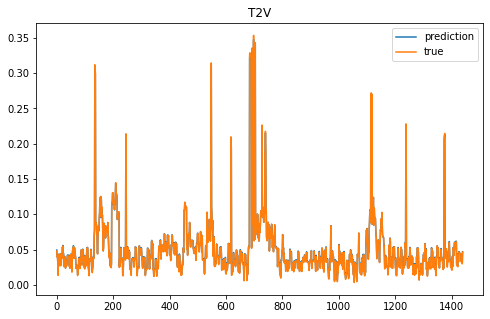

In [18]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 1 ###

plt.figure(figsize=(8,5))

y_pred_unfolded_h1 = unfold_sequence(y_pred_h1, SEQUENCE_LENGTH, OVERLAP_PERIOD)
y_test_unfolded_h1 = unfold_sequence(y_test_h1, SEQUENCE_LENGTH, OVERLAP_PERIOD)

plt.plot(y_pred_unfolded_h1[:24*60], label='prediction')
plt.plot(y_test_unfolded_h1[:24*60], label='true')
plt.title('T2V');
plt.legend();

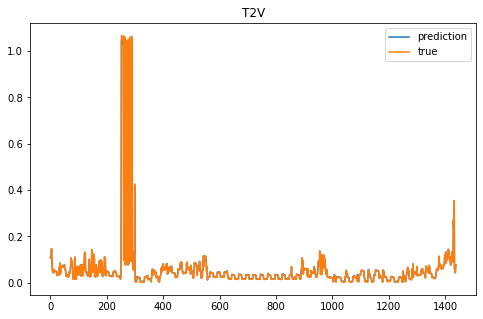

In [19]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 2 ###

plt.figure(figsize=(8,5))

y_pred_unfolded_h2 = unfold_sequence(y_pred_h2, SEQUENCE_LENGTH, OVERLAP_PERIOD)
y_test_unfolded_h2 = unfold_sequence(y_test_h2, SEQUENCE_LENGTH, OVERLAP_PERIOD)

plt.plot(y_pred_unfolded_h2[:24*60], label='prediction')
plt.plot(y_test_unfolded_h2[:24*60], label='true')
plt.title('T2V');
plt.legend();

Now that our Time2Vec model is trained, we can use its embedding as a first layer of neural network for a binary classification task.

# 2. Using our embeddings for classification

In [14]:
def get_scores(y_test, y_pred, dataset, seq_length, overlap_period):
    y_pred_unfolded = unfold_sequence(y_pred, seq_length, overlap_period)
    y_test_unfolded = unfold_sequence(y_test, seq_length, overlap_period)

    mod.plot_confusion_matrix(y_test_unfolded, (y_pred_unfolded>0.5).astype(int));

    train_dim_tot = int(0.7*len(dataset))
    dataset_res = dataset.copy()
    dataset_res['activity_pred'] = np.nan
    #house1_power_blk2_res['activity_pred'].iloc[train_dim_h1_tot:-SEQUENCE_LENGTH:step] = (y_pred_h1[:, 0].reshape(-1) > 0.5).astype(int)
    #house1_power_blk2_res.iloc[train_dim_h1_tot:-SEQUENCE_LENGTH:step].head()

    offset = len(dataset_res.iloc[train_dim_tot:, :]) - len(y_pred_unfolded)
    dataset_res.iloc[train_dim_tot:-offset, -1] = (y_pred_unfolded > 0.5).astype(int)
    
    fig, ax = plt.subplots()

    mod.plot_activity_hist(dataset_res['activity_pred'].iloc[train_dim_tot:-offset] , figsize=(12, 6), alpha=0.5, label='predictions', ax=ax) 
    mod.plot_activity_hist(dataset_res['activity'].iloc[train_dim_tot:-offset], figsize=(12, 6), alpha=0.5, label='truth', color='tab:orange', ax=ax)

In [15]:
X_h2, Y_h2 = [], []
for sequence in gen_sequence(house2_power_blk1, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    X_h2.append(sequence)

# gen_labels
for sequence in gen_sequence(house2_power_blk1, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['activity']):
    Y_h2.append(sequence)
    
X_h2 = np.asarray(X_h2)
Y_h2 = np.asarray(Y_h2)

In [16]:
### TRAIN TEST SPLIT ###
step = SEQUENCE_LENGTH - OVERLAP_PERIOD
train_dim_h2 = int(0.7*len(house2_power_blk1) / step)
X_train_h2, X_test_h2 = X_h2[:train_dim_h2], X_h2[train_dim_h2:]
y_train_h2, y_test_h2 = Y_h2[:train_dim_h2], Y_h2[train_dim_h2:]

print(X_train_h2.shape, y_train_h2.shape)
print(X_test_h2.shape, y_test_h2.shape)

(4959, 40, 1) (4959, 40, 1)
(2121, 40, 1) (2121, 40, 1)


In [17]:
X_h1, Y_h1 = [], []
for sequence in gen_sequence(house1_power_blk2, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    X_h1.append(sequence)

# gen_labels
for sequence in gen_sequence(house1_power_blk2, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['activity']):
    Y_h1.append(sequence)
    
X_h1 = np.asarray(X_h1)
Y_h1 = np.asarray(Y_h1)

In [18]:
### TRAIN TEST SPLIT ###
step = SEQUENCE_LENGTH - OVERLAP_PERIOD
train_dim_h1 = int(0.7*len(house1_power_blk2) / step)
X_train_h1, X_test_h1 = X_h1[:train_dim_h1], X_h1[train_dim_h1:]
y_train_h1, y_test_h1 = Y_h1[:train_dim_h1], Y_h1[train_dim_h1:]

print(X_train_h1.shape, y_train_h1.shape)
print(X_test_h1.shape, y_test_h1.shape)

(5288, 40, 1) (5288, 40, 1)
(2262, 40, 1) (2262, 40, 1)


In [19]:
### RE-DEFINE T2V LAYER ###

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [20]:
### DEFINE CLASSIFICATION MODEL STRUCTURES ###

def T2V_NN_C(param, dim):
    
    # set_seed(33)
    
    inp = Input(shape=(dim,1))
    #x = Dropout(0.2)(inp)
    x = T2V(param['t2v_dim'])(inp)
    x = Dropout(0.2)(x)
    # x = LSTM(param['unit'], activation=param['act'], return_sequences=True)(x)
    # we want to make a classification with 2 classes
    x = Dense(1, activation='sigmoid')(x)
    #x = BatchNormalization()(x)
    #x = Activation('sigmoid')(x)
    
    m = Model(inp, x)
    m.compile(loss='bce', optimizer='adam') #Adam(learning_rate=param['lr'])
    
    return m

In [21]:
### LOAD OUR WEIGHTS ###
#t2v_weights = pickle.load(open('t2v_weights_norm_lstm_house2.pkl', 'rb'))
t2v_weights = kgs_t2v.layers[1].get_weights()

early_stop = EarlyStopping(patience=5, verbose=0, min_delta=0.0001, monitor='loss', mode='auto', restore_best_weights=True)
best_params = {'unit': 32, 't2v_dim': 128, 'epochs': 12, 'act': 'relu', 'batch_size': 1024}
kgs_t2v_c = T2V_NN_C(param=best_params, dim=SEQUENCE_LENGTH)

kgs_t2v_c.layers[1].set_weights(t2v_weights)

# to ensable fine-tuning
kgs_t2v_c.layers[1].trainable = True

kgs_t2v_c.summary();

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 1)]           0         
                                                                 
 t2v_1 (T2V)                 (None, 40, 129)           5328      
                                                                 
 dropout_1 (Dropout)         (None, 40, 129)           0         
                                                                 
 dense_1 (Dense)             (None, 40, 1)             130       
                                                                 
Total params: 5,458
Trainable params: 5,458
Non-trainable params: 0
_________________________________________________________________


## Let's train our model on house 1.

In [22]:
kgs_t2v_c.fit(X_train_h1, y_train_h1, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

Epoch 1/12
6/6 [==============================] - 1s 23ms/step - loss: 0.6911
Epoch 2/12
6/6 [==============================] - 0s 26ms/step - loss: 0.6889
Epoch 3/12
6/6 [==============================] - 0s 26ms/step - loss: 0.6868
Epoch 4/12
6/6 [==============================] - 0s 27ms/step - loss: 0.6849
Epoch 5/12
6/6 [==============================] - 0s 28ms/step - loss: 0.6828
Epoch 6/12
6/6 [==============================] - 0s 27ms/step - loss: 0.6807
Epoch 7/12
6/6 [==============================] - 0s 28ms/step - loss: 0.6786
Epoch 8/12
6/6 [==============================] - 0s 29ms/step - loss: 0.6765
Epoch 9/12
6/6 [==============================] - 0s 31ms/step - loss: 0.6743
Epoch 10/12
6/6 [==============================] - 0s 30ms/step - loss: 0.6721
Epoch 11/12
6/6 [==============================] - 0s 29ms/step - loss: 0.6698
Epoch 12/12
6/6 [==============================] - 0s 29ms/step - loss: 0.6676


We can now make predictions and have a look at the performances. Let's have a look at the score on the test dataset from house 1.

Score f_beta : 53.507%
Score accuracy : 60.809%


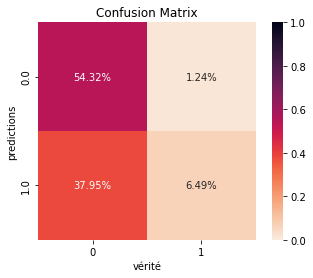

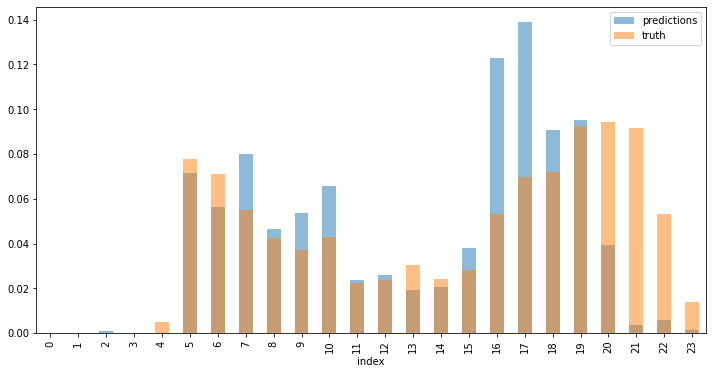

In [23]:
# y_pred_h1 = kgs_t2v_c.predict(X_test_h1)
# y_pred_unfolded_h1 = unfold_sequence(y_pred_h1, SEQUENCE_LENGTH, OVERLAP_PERIOD)
# y_test_unfolded_h1 = unfold_sequence(y_test_h1, SEQUENCE_LENGTH, OVERLAP_PERIOD)

# mod.plot_confusion_matrix(y_test_unfolded_h1, (y_pred_unfolded_h1>0.5).astype(int));

y_pred_h1 = kgs_t2v_c.predict(X_test_h1)
get_scores(y_test_h1, y_pred_h1, house1_power_blk2, SEQUENCE_LENGTH, OVERLAP_PERIOD)

Now let's have a look at the score on the test dataset from house 2.

Score f_beta : 54.310%
Score accuracy : 62.164%


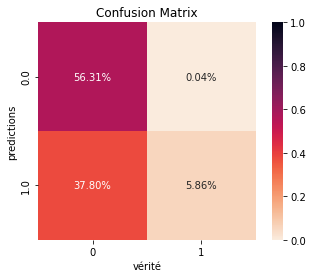

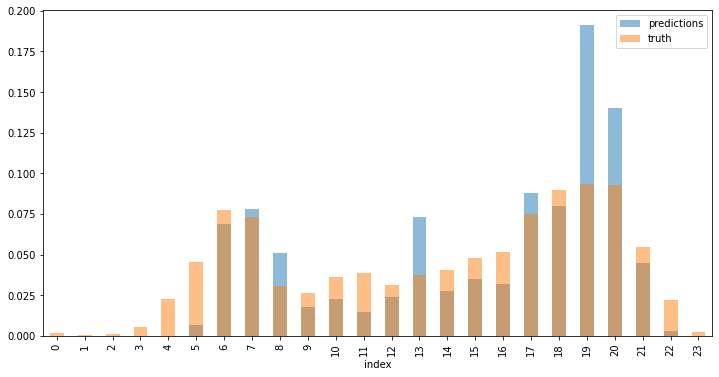

In [105]:
y_pred_h2 = kgs_t2v_c.predict(X_test_h2)
get_scores(y_test_h2, y_pred_h2, house2_power_blk1, SEQUENCE_LENGTH, OVERLAP_PERIOD)

## Now let's train a new model on house 2.

In [24]:
### LOAD OUR WEIGHTS ###
#t2v_weights = pickle.load(open('t2v_weights_norm_lstm_house2.pkl', 'rb'))
t2v_weights = kgs_t2v.layers[1].get_weights()

early_stop = EarlyStopping(patience=5, verbose=0, min_delta=0.0001, monitor='loss', mode='auto', restore_best_weights=True)
best_params = {'unit': 32, 't2v_dim': 128, 'epochs': 12, 'act': 'relu', 'batch_size': 1024}
kgs_t2v_c = T2V_NN_C(param=best_params, dim=SEQUENCE_LENGTH)

kgs_t2v_c.layers[1].set_weights(t2v_weights)


kgs_t2v_c.fit(X_train_h2, y_train_h2, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

Epoch 1/12
5/5 [==============================] - 1s 26ms/step - loss: 0.6923
Epoch 2/12
5/5 [==============================] - 0s 28ms/step - loss: 0.6880
Epoch 3/12
5/5 [==============================] - 0s 30ms/step - loss: 0.6846
Epoch 4/12
5/5 [==============================] - 0s 31ms/step - loss: 0.6824
Epoch 5/12
5/5 [==============================] - 0s 31ms/step - loss: 0.6808
Epoch 6/12
5/5 [==============================] - 0s 33ms/step - loss: 0.6793
Epoch 7/12
5/5 [==============================] - 0s 31ms/step - loss: 0.6776
Epoch 8/12
5/5 [==============================] - 0s 33ms/step - loss: 0.6761
Epoch 9/12
5/5 [==============================] - 0s 31ms/step - loss: 0.6745
Epoch 10/12
5/5 [==============================] - 0s 31ms/step - loss: 0.6728
Epoch 11/12
5/5 [==============================] - 0s 31ms/step - loss: 0.6713
Epoch 12/12
5/5 [==============================] - 0s 30ms/step - loss: 0.6697


Let's have a look at the score on the test dataset from house 1.

Score f_beta : 45.534%
Score accuracy : 58.223%


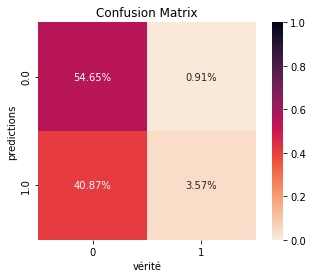

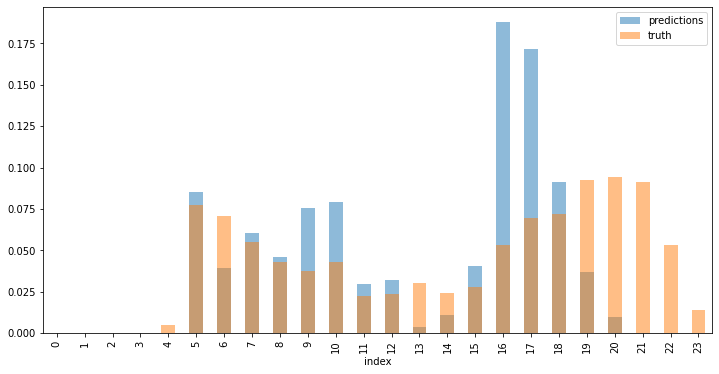

In [25]:
y_pred_h1 = kgs_t2v_c.predict(X_test_h1)
get_scores(y_test_h1, y_pred_h1, house1_power_blk2, SEQUENCE_LENGTH, OVERLAP_PERIOD)

Now let's have a look at the score on the test dataset from house 2.

Score f_beta : 41.925%
Score accuracy : 58.534%


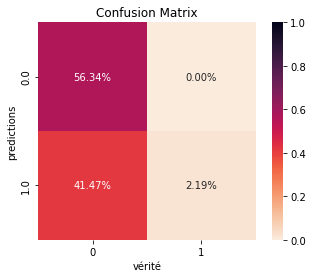

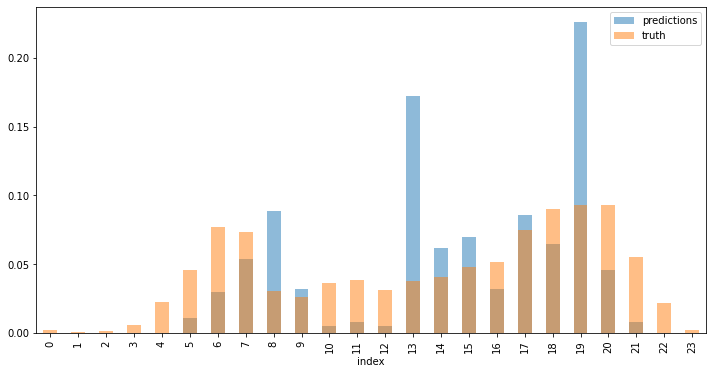

In [26]:
y_pred_h2 = kgs_t2v_c.predict(X_test_h2)
get_scores(y_test_h2, y_pred_h2, house2_power_blk1, SEQUENCE_LENGTH, OVERLAP_PERIOD)

Finally we can try to plot our predictions.

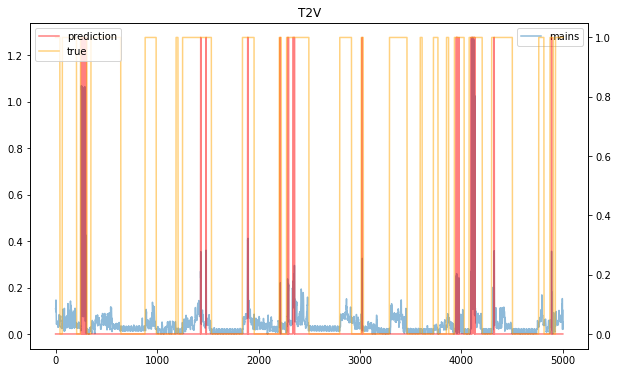

In [39]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 2 ###
X_test_unfolded_h2 = unfold_sequence(X_test_h2, SEQUENCE_LENGTH, OVERLAP_PERIOD)
y_pred_unfolded_h2 = unfold_sequence(y_pred_h2, SEQUENCE_LENGTH, OVERLAP_PERIOD)
y_test_unfolded_h2 = unfold_sequence(y_test_h2, SEQUENCE_LENGTH, OVERLAP_PERIOD)

fig, ax = plt.subplots(1,1 , figsize=(10,6))
axs = ax.twinx()

ax.plot(X_test_unfolded_h2[:5000], label='mains', alpha=0.5)
axs.plot(y_pred_unfolded_h2[:5000]>0.5, label='prediction', color='red', alpha=0.5)
axs.plot(y_test_unfolded_h2[:5000], label='true', color='orange', alpha=0.5)
plt.title('T2V');
ax.legend(loc='upper right');
axs.legend(loc='upper left');

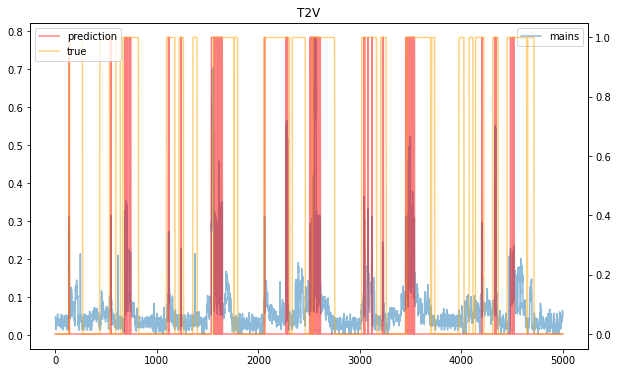

In [40]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 1 ###
X_test_unfolded_h1 = unfold_sequence(X_test_h1, SEQUENCE_LENGTH, OVERLAP_PERIOD)
y_pred_unfolded_h1 = unfold_sequence(y_pred_h1, SEQUENCE_LENGTH, OVERLAP_PERIOD)
y_test_unfolded_h1 = unfold_sequence(y_test_h1, SEQUENCE_LENGTH, OVERLAP_PERIOD)

fig, ax = plt.subplots(1,1 , figsize=(10,6))
axs = ax.twinx()

ax.plot(X_test_unfolded_h1[:5000], label='mains', alpha=0.5)
axs.plot(y_pred_unfolded_h1[:5000]>0.5, label='prediction', color='red', alpha=0.5)
axs.plot(y_test_unfolded_h1[:5000], label='true', color='orange', alpha=0.5)
plt.title('T2V');
ax.legend(loc='upper right');
axs.legend(loc='upper left');

Looking at the plots, it looks like our model sucessfully identifies the period of times with a lot of variation on the load curve.

Let's have a look at the output of our network T2V + LSTM. We'll performe a PCA to get the 2 main axis and project the resulats onto a 2D plane.

In [45]:
def T2V_NN_Partial(param, dim):
    
    # set_seed(33)
    
    inp = Input(shape=(dim,1))
    #x = Dropout(0.2)(inp)
    x = T2V(param['t2v_dim'])(inp)
    # x = LSTM(param['unit'], activation=param['act'], return_sequences=True)(x)

    m = Model(inp, x)
    m.compile(loss='bce', optimizer='adam') #Adam(learning_rate=param['lr'])
    
    return m

In [46]:
kgs_t2v_part = T2V_NN_Partial(param=best_params, dim=SEQUENCE_LENGTH)

t2v_weights = kgs_t2v_c.layers[1].get_weights()
#lstm_weights = kgs_t2v_c.layers[3].get_weights()

kgs_t2v_part.layers[1].set_weights(t2v_weights)
#kgs_t2v_part.layers[2].set_weights(lstm_weights)

# to disable fine-tuning
kgs_t2v_part.layers[1].trainable = False
#kgs_t2v_part.layers[2].trainable = False

t2v_lstm_out = kgs_t2v_part.predict(X_test_h1)

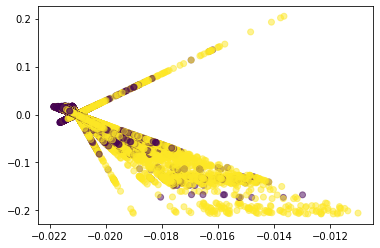

In [47]:
for i in range(SEQUENCE_LENGTH):
    #vect_norms = np.sqrt(np.sum(t2v_lstm_out[:,i] ** 2, axis=1))
    #t2v_weights_norm = t2v_lstm_out[:,i] / vect_norms[:,np.newaxis]
    U, _, _ = np.linalg.svd(t2v_lstm_out[:,i])

    plt.scatter(U[:,0], U[:,1], c=y_test_h1[:,i], alpha=0.5);